## FRAME CLASSIFICATION using GMM's
### Comparing different Feature Vectors: Filterbanks vs. PCA vs. Cepstral features
+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History: --/--/2020, 25/04/2022
+ ###### Requires:  pyspch>=0.7 

### 1. Setting up
- some code to avoid memory leaks and excessive number of warnings
- import pyspch if necessary
- complete all the necessary imports, and define some visualization parameters

In [1]:
####################################################################################
### This setting is to avoid memory leaks in sklearn KMEANS on windows+MKL machines 
### This must be executed before importing numpy (here or in other packages) 
import os
os.environ["OMP_NUM_THREADS"] = '1'  
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import sys,os,io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# import from the scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
# import the DCT transform from scipy
from scipy.fftpack import dct

from pyspch.stats import GMM
import pyspch.core as Spch

palette = sns.color_palette("bright")
sns.set_palette(palette)
pd.set_option('display.precision',2)

mpl.rcParams['figure.figsize'] = [10.0, 10.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### 2. The Database 
The experiments in this notebook use a subset of the [TIMIT](../data/TIMIT.md) database.
TIMIT contains phoneme segmentations that we used to randomly select 1000 frames each for the   3 vowels  (aa, iy, uw). 800 samples per class are used for training and 200 samples for testing.
In this way we create a very simple 3 class recognition problem.

We start from MEL SCALED FILTERBANK that can be loaded as 'tinytimit', the input feature vectors 
consist of the log energies of 24 mel filterbank channels.

The loaded data consists of:
- data matrices   MELFB_train(2400,24), MELFB_test(600,24)
- labels          y_train(2400,), y_test(600,)

In [4]:
(MELFB_train, MELFB_test, y_train, y_test) = Spch.load_data('tinytimit')
classes = ['aa','iy','uw']

## 3. Data Exploration 

### 3a. Mel Filterbank data

How to explore data in 24-dimensional space ?

There is no trivial answer to this question.  
First we try to visualize scatter plots of the first couple of filterbank energies

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can combine a collection of scatter plots for a better overview as in the gridplot below

##### Tasks & Questions (1)
1. In what sense does this data look different from Formant data used in previous exercises ?
2. What do the scatter plots tell you.  Are there features that must be retained or others that can be dropped without risk ?

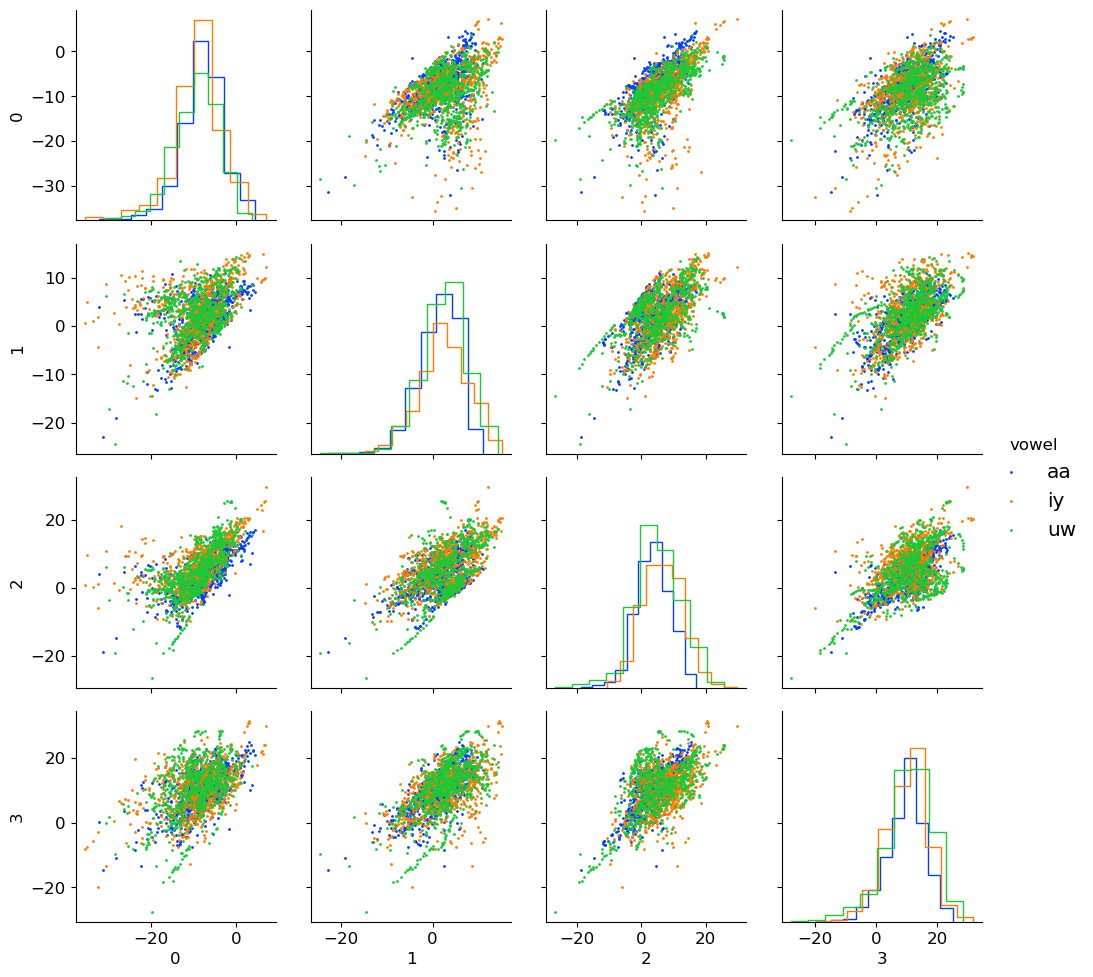

In [5]:
# we use the sns.PairGrid method to construct a multitude of scatter plots over the first 
# filterbank coefficients
dfX = pd.DataFrame(MELFB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#f=plt.figure(figsize=(10,10))
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 3b. Principle Component Analysis (PCA)

While there might be lots of information in this 24-dimensional data. It is not simple to observe it.
Definitely it is not obvious in the first couple of filterbank coefficients as we run into the limitations of our 2-D/3-D visual perception system. 

A common approach for a quick analysis is to project the data on its most important axes by Principal Component Analysis (PCA).   PCA takes a view at the overall data distribution and then projects the data on a number of axes that explain
the data variability best. 
PCA does not look at data labels, hence it is an unsupervised method. 
We will not give any mathematical background here, but just think of looking in the best possible low-dimensional subspace of the full 24-dimensional space.

The scatterplot shows the data along the 2 principle axes.
The gridplot combines scatterplots of different (low order) PCA coefficients; the bottom left hand side of the plots show the raw datapoints; the top right hand side shows density approximations.

##### Tasks & Questions (2)
1. What do these new scatter plots tell you?  Can you make a general statement about the distributions of PCA features ?
2. In what units are the PCA-axis ?
3. Any idea if the original filterbank features will perform better or worse than the PCA features ?
4. If you may only use 2 PCA coefficients, which ones will you choose ?

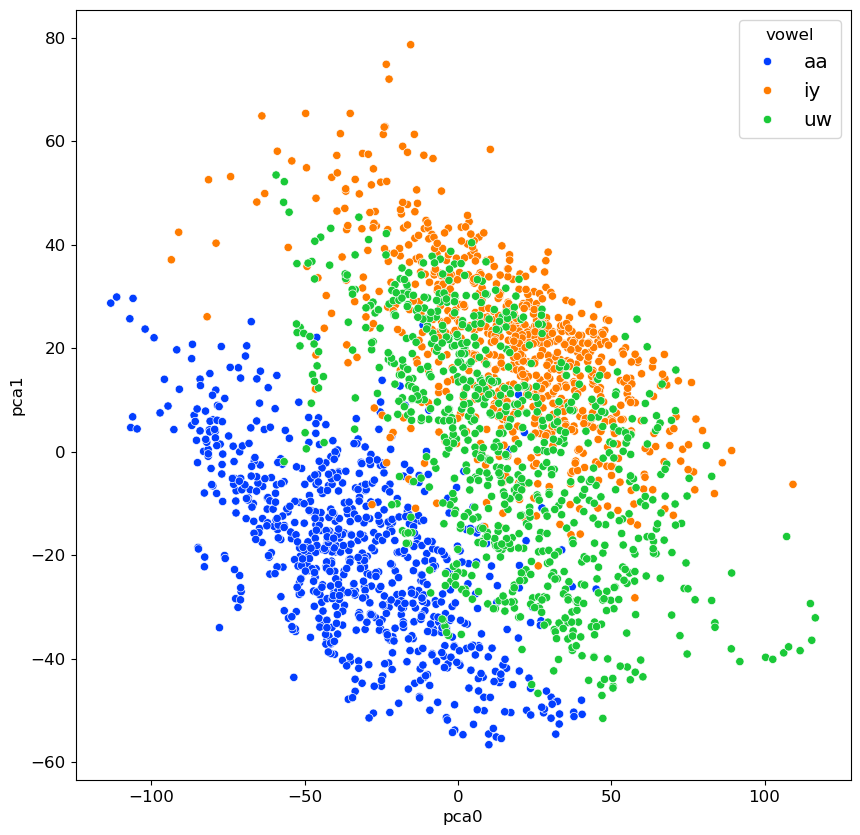

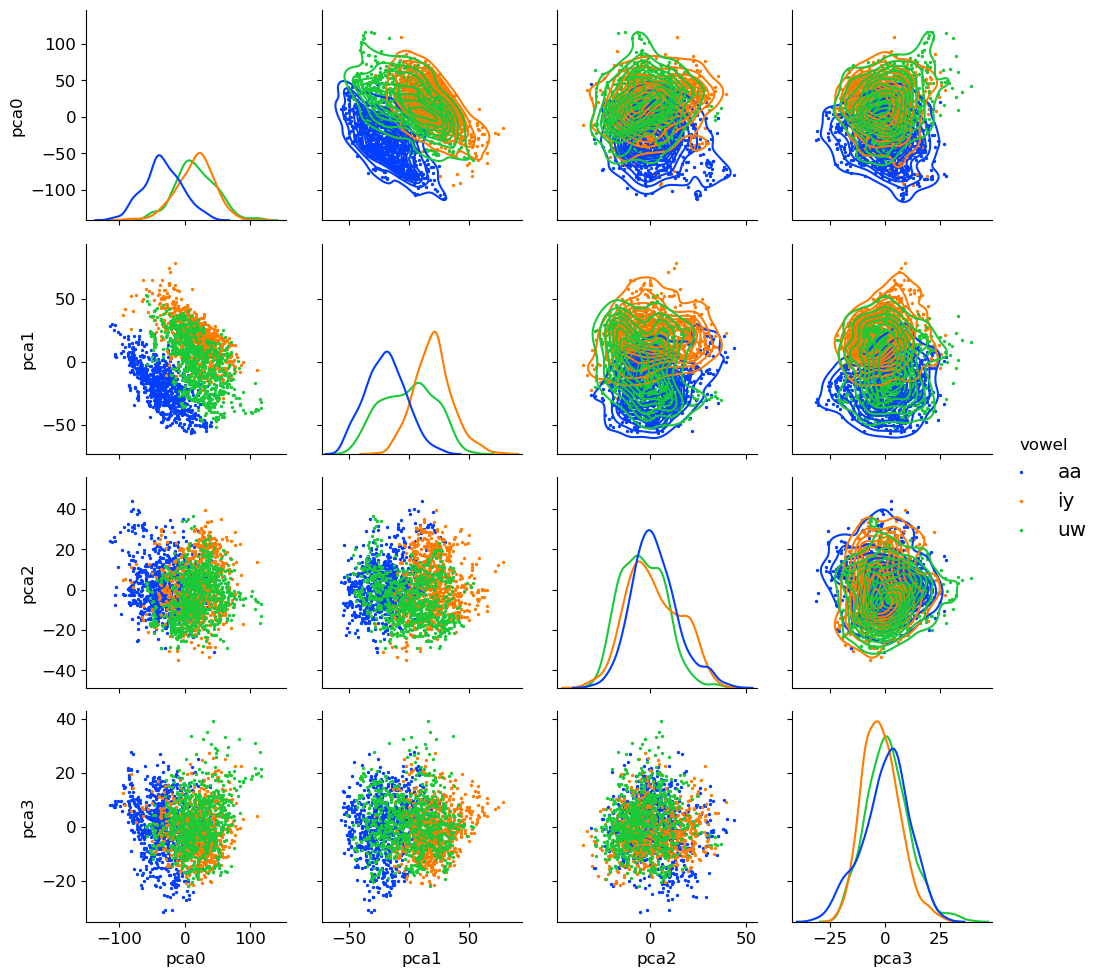

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
T = pca.fit(MELFB_train)
PCA_train = T.transform(MELFB_train)
PCA_test = T.transform(MELFB_test)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#
df.columns=["vowel","pca0","pca1","pca2","pca3"]
sns.scatterplot(data=df,x="pca0",y="pca1",hue='vowel')
g = sns.PairGrid(df,hue="vowel")
# on the diagonal we can plot a histogram or a smooth kernel density plot
#g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter,s=2)
g.map_upper(sns.kdeplot)
g.add_legend()

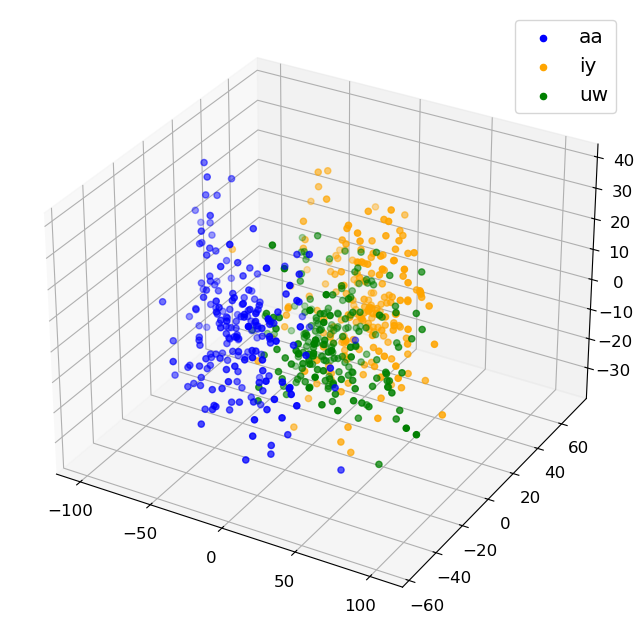

In [7]:
# we can also try to look in 3D ...
# .. but that's the limit of our visual capacity and the data is still 24-D !
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[0:200,"pca0"], df.loc[0:200,"pca1"], df.loc[0:200,"pca2"], c='blue', s=20)
ax.scatter(df.loc[800:1000,"pca0"], df.loc[800:1000,"pca1"], df.loc[800:1000,"pca2"], c='orange', s=20)
ax.scatter(df.loc[1600:1800,"pca0"], df.loc[1600:1800,"pca1"], df.loc[1600:1800,"pca2"], c='green', s=20)
plt.legend(['aa','iy','uw'])
plt.show()


### 3c. MFCC features

PCA is a very common technique in machine learning in general to achieve dimensionality reduction, especially when we are dealing with unsupersived settings. It is not commonly used in tasks where we have plenty of labeled data, as is the case for speech recognition.   In such circumstances two alternatives give consistently better performance: LDA or CEPSTRAL transformations.  LDA is a generic technique that learns an optimal linear transformation from labeled data, the cepstrum is a deterministic technique known to work well with speech filterbank data.
Both are linear transformations, similar to PCA, but conceptually quite different
- PCA looks at the global data and gives a look along the most informative axes.  After transformation the global data is centered at the origin and almost normally distributed.
- LDA is also a global transformation, however it takes class information into account in its optimization criterion.  LDA makes gross assumptions, namely that all classes are normally distributed with identical covariances.  Despite these unrealistic assumptions, LDA tends to  outperform PCA by a rather large margin in most machine learning tasks, including speech recognition. Another disadvantage of LDA is that it is learned from the labeled data, making it dependent on language, task and even database.
- The Cepstrum: is derived from the spectrum or filterbank energies via a DCT transform.  Its performance is close to LDA and has as great advantage that it is deterministic (not learned).  Also - almost magically - cepstral features are highly decorrelated and almost normally distributed making them very well suited for machine learning applications.   When the DCT is applied on a mel scaled spectrum (or mel filterbank energies) we call the output MEL FREQUENCY CEPSTRAL COEFFICIENTS (or MFCCs).   A final advantage of these MFCCs is that most speech information is captured in the lowest coefficients and that higher order coefficients can be dropped without significant loss of information.  As such MFCCs are very compact, making them "cheap" to work with. For all these reasons MFCCs have been a reference feature representation for speech recognition for decades.  While maybe not the best anymore, they are still very relevant for development, prototyping or embedded applications.


#### MFCC's: Computation
MFCC's are obtained by taking a DCT (discrete cosine transform) of log filterbank energies.
The MELFB features we start from in this exercise are these log filterbank energies.
 
In the first set of figures we compare side by side prototypical spectra with prototypical cepstra of our 3 vowels in the database.  You can turn on/off optional mean normalization such that the global distributions become zero-centered.  While the spectra are more intuitive, we will later see the power of the cepstral coefficients.  Note already 
that the MELFB's here are 24-Dimensional, while we limited the dimensionality of the cepstra to 13. 

The second set of figures shows scattered plots as with PCA features.

#### Tasks & Questions (3)
1. What do these new scatter plots tell you?
2. In what units are the MFCC-axis ?
3. Any preferred features by now ?
4. Anything remarkable about the global variance of cepstral coefficients ? How would the plot of the prototyical cepstra look if we had applied mean **and** variance normalization ?


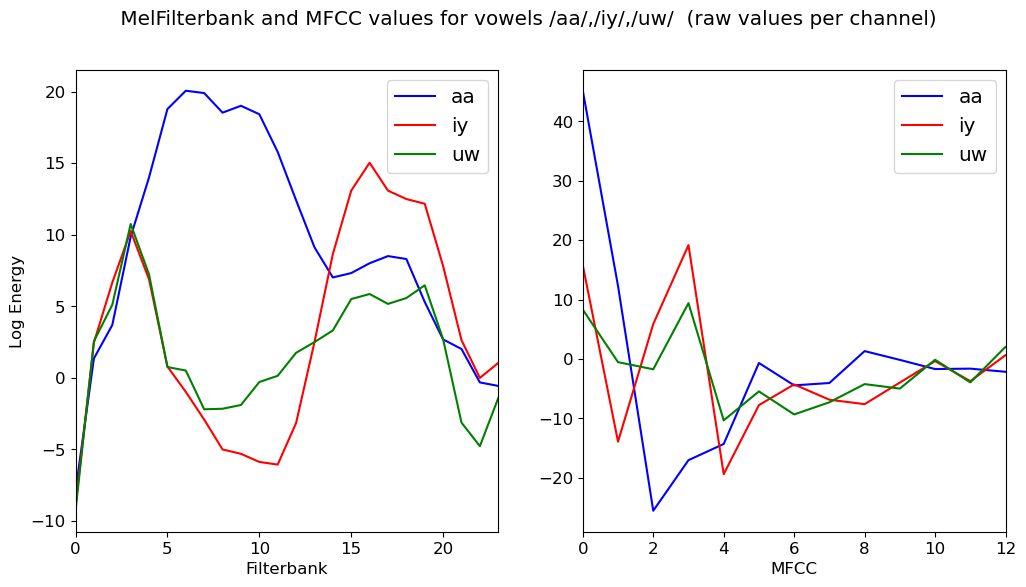

In [8]:
#  set MEAN_NORM to True if you want to display mean normalized values
#  leave MEAN_NORM at False if you want to display raw values
MEAN_NORM = False

MFCC_train = dct(MELFB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(MELFB_test, type=2, axis=1, norm='ortho')


if MEAN_NORM:
  MELFBmean = np.mean(MELFB_train,0)
  MFCCmean = np.mean(MFCC_train,0)
else:
  MELFBmean = 0
  MFCCmean = 0

MELFB_typ_aa = np.mean(MELFB_train[0:800,:],0) - MELFBmean
MELFB_typ_iy = np.mean(MELFB_train[800:1600,:],0) - MELFBmean
MELFB_typ_uw = np.mean(MELFB_train[1600:2400,:],0) - MELFBmean
MFCC_typ_aa = np.mean(MFCC_train[0:800,:],0) - MFCCmean
MFCC_typ_iy = np.mean(MFCC_train[800:1600,:],0) -MFCCmean
MFCC_typ_uw = np.mean(MFCC_train[1600:2400,:],0) -MFCCmean


fig= plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)
ax.plot(MELFB_typ_aa,color='blue')
ax.plot(MELFB_typ_iy,color='red')
ax.plot(MELFB_typ_uw,color='green')
ax.legend(['aa','iy','uw'])
ax.set_xlabel('Filterbank')
ax.set_xlim(0,23)
ax.set_ylabel('Log Energy')
#plt.show()

ax = fig.add_subplot(122)
ax.plot(MFCC_typ_aa,color='blue')
ax.plot(MFCC_typ_iy,color='red')
ax.plot(MFCC_typ_uw,color='green')
ax.legend(['aa','iy','uw'])
ax.set_xlabel('MFCC')
ax.set_xlim(0,12)
ax.set_ylabel('')
if MEAN_NORM:
  plt.suptitle(' MelFilterbank and MFCC values for vowels /aa/,/iy/,/uw/  (mean normalization per channel)')
else:
  plt.suptitle(' MelFilterbank and MFCC values for vowels /aa/,/iy/,/uw/  (raw values per channel)')
#plt.savefig("vow3_MELFBvsMFCC")
plt.show()

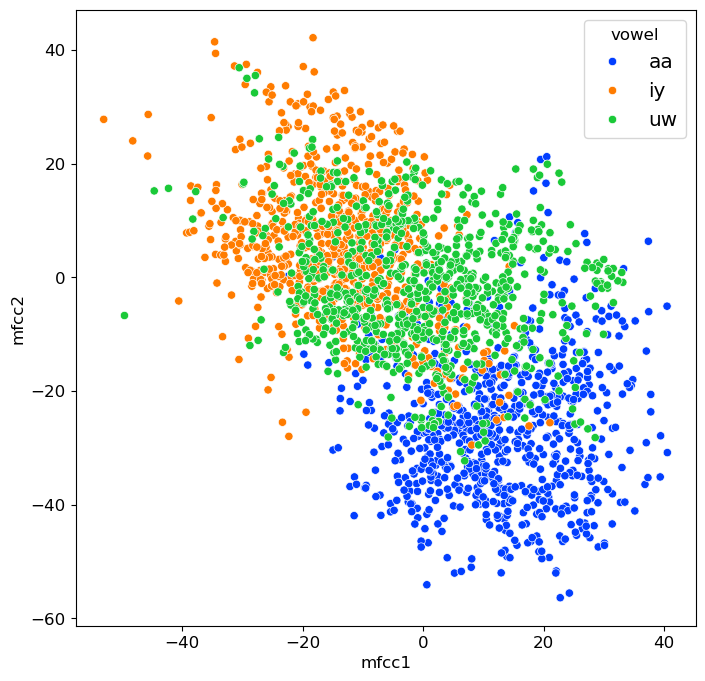

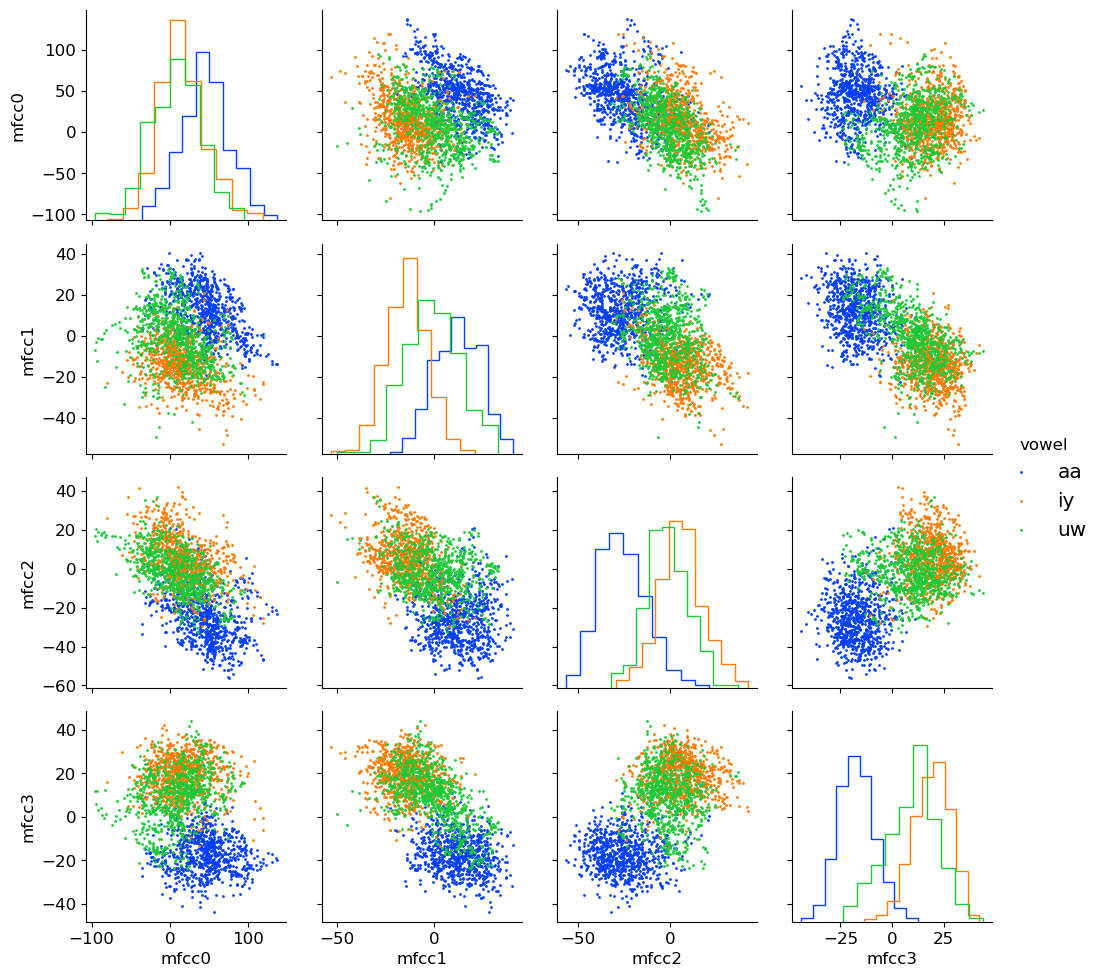

In [9]:
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
df.columns=["vowel","mfcc0","mfcc1","mfcc2","mfcc3"]
#
f=plt.figure(figsize=(8,8))
sns.scatterplot(data=df,x="mfcc1",y="mfcc2",hue='vowel')
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 4. Classification using Gaussian Mixture models

We will now explore the merit of the different representations in function of speech recognition performance.   For modeling we use Gaussian Mixture Models and the inference is straightforward Bayesian.   
##### Implementation
We use the implementation as provided in the class *GMM* implemented in *pyspch.stats*. 
It is implemented as an extension to *sklearn*, using the same APIs and making use of the sklearn GaussianMixture density estimator.

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian Mixture Model
- n_dim: the dimension of the feature vector (should be less than 24 in all cases)
- feature_type: "MFCC", "MELFB" or "PCA"
- max_iter:  maximum number of iterations in EM algorithm 

##### Training Criteria
GMMs are trained using the EM algorithm which is a hill climbing procedure.  The theory says that the likelihood will increase with every iteration. (Verifying this is in any case a good sanity check for your code!)  But what is now a good stopping criterion ?  

   + Having too many iterations is likely will lead to overfitting the data; i.e. you still see improvement on the training data but you observe degrading performance on the test data.
   + When do we train 'enough' and not 'too much' ?
       - you should stop training when the improvement in LL is marginal, but what is marginal
       - the BIC (Bayesian Information Criterion) may give a hint. It gives a combined measure of goodness of fit (likelihood) and complexity of the model (number of parameters)
       - Best practice, however, is to use an independent validation set (a test set used during training) and to stop when performance on the validation set starts detereorating
    
    
##### Final Performance Measures
The performance measures we report (apart from LL and BIC) are:
- error rate: on (traning set and) an independent test set
- confusion matrix: given some insight in the specific errors we can expect



##### Task & Questions (4)
1. How important in n_dim ?
2. How important is n_components ?
3. How important is it in this case to do PCA first ?
4. How similar is test performance on an independent test set when compared with predicted performance from train set ?  Do you see differences between the 3 different feature types?  Do you see differences with increasing feature dimension and number of components ?

In [10]:
# sklearn is not the most solid implementation of GMMs and produce
# quite a few warnings, which we neglect to focus on other relevant parameters
#
# if you want to see LL evolve during training, you should add
#  "verbose=0,verbose_interval=1" to the GMM parameters
#
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def train_model(X_train,y_train,classes,n_components=1,max_iter=10,tol=1.e-2,Verbose=False):
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,tol=tol)
    clf_GMM.fit(X_train,y_train)
    ll, bic = clf_GMM.ll_and_bic(X_train,y_train)
    y_pred = clf_GMM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
        print('Training Measures: LL(per sample) = %.2f    BIC = %.2f ' % (ll,bic) )
    return(clf_GMM,(acc_train,ll,bic))    

def test_model(clf_GMM,X_test,y_test,Verbose=False):
    y_pred = clf_GMM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        Spch.plot_confusion_matrix(conf_mat,labels=classes)
    return(acc_test,conf_mat)


*** feature_type=MFCC, dim=13, n_components=2 ***
Training Set:  Accuracy = 84.21%
Training Measures: LL(per sample) = -44.67    BIC = 215656.07 
Test Set:      Accuracy = 82.50%


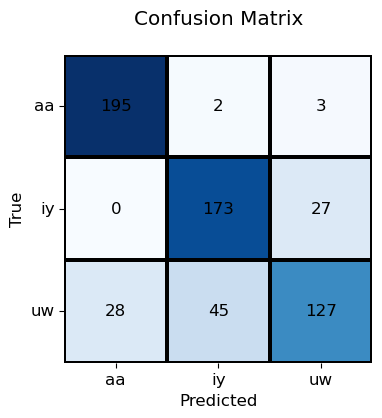

Class[0] (aa) with prior=0.333
-----------------------------------
0.44309658297531884 [ 27.91610884  19.81979164 -20.17522423 -18.23206832 -15.28476334
  -2.47698603  -2.22888432  -7.6530888    1.39706209  -0.82632777
   1.10104311  -1.36005009  -3.61604808] [674.66057592  98.34939261 180.43390204  94.23275875 134.95042241
  85.30387122  62.59681045  41.97686338  36.74730696  28.16446812
  29.95772836  35.59408763  28.63551222]
0.5569034170246812 [ 58.88197215   6.27485309 -29.85809758 -16.11642073 -13.56243648
   0.73357854  -6.2342908   -1.19995764   1.24455913   0.35797316
  -3.94277912  -1.86361572  -1.02302791] [693.75562356  87.96210563 114.01407008  63.52854609  54.70087851
  43.99714486  28.67479232  34.85762523  23.34477573  45.38207228
  14.93638847  12.80548982  25.77138681]

Class[1] (iy) with prior=0.333
-----------------------------------
0.4724256400370689 [ 28.20836178 -14.14825195  -1.15136155  21.97781511 -13.96478096
 -13.17054012  -3.3672299   -5.74771409  -6.50766

In [11]:
# just running the model for a single setup
#
feature_type = "MFCC"  # any of MFCC, MELFB or PCA
n_dim = 13            #  feature dimensions to test
ftr_slice = slice(0,n_dim)  # by default 0:n_dim, other slices possible 
n_components = 2      #  number of GMM components
max_iter = 4
#
print("*** feature_type=%s, dim=%d, n_components=%d ***" % (feature_type,n_dim,n_components))    
X_train = eval("%s_train[:,ftr_slice]"%feature_type)
X_test = eval("%s_test[:,ftr_slice]"%feature_type)
clf,_ = train_model(X_train,y_train,classes=classes,n_components=n_components,max_iter=max_iter,Verbose=True)
_ = test_model(clf,X_test,y_test,Verbose=True)
# model prints mixture weights, means and variances per component per class
clf.print_model()

In [23]:
# in this cell you can do a full scale analysis with multiple settings
# it basically lets you iterate over the same parameters as above
# and summarizes your results in a table

# --------------
feature_type_test = ["MELFB","PCA","MFCC"]   # any of MFCC, FB or PCA
n_dim_test = [ 2, 4, 8, 12, 16, 24 ]            # list of feature dimensions to test
n_components_test = [1, 2, 4,8,  16]                    # list of n_components to test
max_iter = 4                                # maximum number of iterations in the EM algorithm

# --------------
result_list=[]
for feature_type in feature_type_test:
    for n_dim in n_dim_test:  
        for n_components in n_components_test:

            X_train = eval("%s_train[:,0:n_dim]"%feature_type)
            X_test = eval("%s_test[:,0:n_dim]"%feature_type)
          
            clf, (acc_train, ll, bic) = train_model(X_train,y_train,classes,
                                n_components=n_components)
            acc_test, _ = test_model(clf,X_test,y_test)
            result_list.append({"features":feature_type,"dim":n_dim,
                                "n_comp":n_components,
                                "acc_train":acc_train,"acc_test":acc_test,
                                "LL":ll,"BIC":bic})
    
df=pd.DataFrame(result_list,columns=["features","dim","n_comp","acc_train","acc_test","LL","BIC"])

In [24]:
df

,features,dim,n_comp,acc_train,acc_test,LL,BIC
0,MELFB,2,1,41.12,42.67,-6.09,29303.35
1,MELFB,2,2,40.96,38.50,-5.98,28897.77
2,MELFB,2,4,43.75,37.50,-5.82,28375.42
3,MELFB,2,8,45.92,33.33,-5.73,28394.35
4,MELFB,2,16,49.46,34.17,-5.67,29037.42
...,...,...,...,...,...,...,...
85,MFCC,24,1,84.38,81.17,-74.05,356568.67
86,MFCC,24,2,85.96,80.17,-72.55,350506.40
87,MFCC,24,4,86.42,77.00,-71.51,347799.90
88,MFCC,24,8,88.67,82.50,-69.90,344663.77


## Detailed Analysis of the Results

1. check the importance of feature representation and number of features used (dim)

- does any of the feature representations perform worse that the others ?
- which of the representations works best with low (8,13) or very low(2) dimensions ?
- naively you would expect the performance to improve with higher input vector dimensionality as more information is preserved.  However this is not always true.  Actually in a few instances the performance drops significantly when the dimensionality is increased.  For which situaties is that the case and how to explain ?

2. check (for MFCC-13) the influence of number of components in the mixture

- explain the discrepancy between training set behaviour and test set behavious 

In [14]:
df1 = df.loc[(df['n_comp']==2) & ( df['dim'].isin([2,8,13,24]) )].drop(columns=['n_comp','LL','BIC'])
df1 #HTML(df1.to_html(index=False))

,features,dim,acc_train,acc_test
1,MELFB,2,40.96,38.50
6,MELFB,8,67.75,67.83
11,MELFB,13,77.00,71.50
16,MELFB,24,78.33,75.33
21,PCA,2,77.38,74.67
26,PCA,8,83.42,80.17
31,PCA,13,84.08,78.00
36,PCA,24,84.04,72.50
41,MFCC,2,73.54,63.33
46,MFCC,8,83.96,83.67


In [15]:
df2 = df.loc[(df['features']=='MFCC') & ( df['dim']==13)].drop(columns=['features','dim'])
df2

,n_comp,acc_train,acc_test,LL,BIC
50,1,84.42,83.33,-45.40,218536.36
51,2,84.29,84.00,-44.64,215494.08
52,4,85.17,81.00,-44.10,214183.79
53,8,87.50,82.33,-43.29,212821.10
54,16,91.08,77.17,-42.14,212330.69


### Plotting Train/Test Accuracies in function of Feature Dimension
The bands reflect different results for different number of components

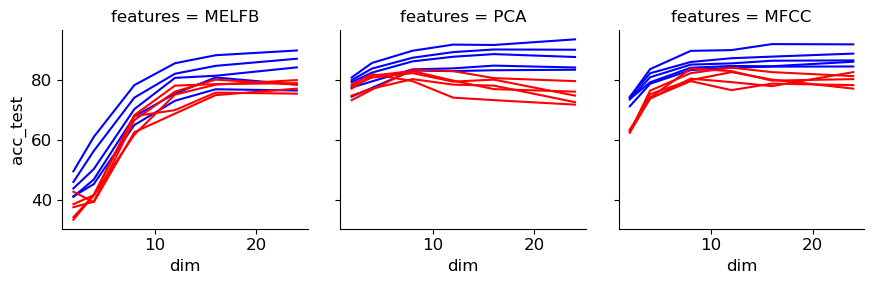

In [79]:
g=sns.FacetGrid(df,col="features",hue="n_comp")
g.map(sns.lineplot,"dim","acc_train",color='b')
g.map(sns.lineplot,"dim","acc_test",color='r')

### Plotting Train/Test Accuracies in function of #components in GMM mixture

The plots below summarize the effect of the number of gaussian in the GMM.  They are just given as such.  Be aware that these results have limited significance given the extremely small size of this dataset.
cfr. the timit-3.ipynb notebook in this folder for more relevant results.

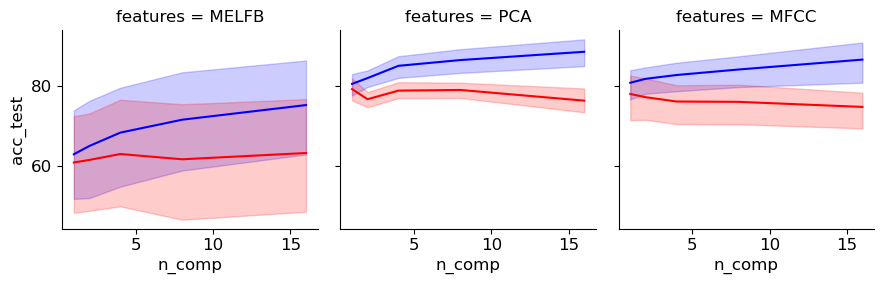

In [75]:
g=sns.FacetGrid(df,col="features") 
g.map(sns.lineplot,"n_comp","acc_train",color='b')
g.map(sns.lineplot,"n_comp","acc_test",color='r')

### 5. Classification using a Neural Net

Finally we compare our classification results using Gaussian Mixtures (GMM) with a Neural Net (NN) classifier.  For this application we may use the simplest of all neural nets: a multilayer perceptron (MLP).

We have set acceptable training parameters for you.  The things we are interested in is the impact of different features (type and dimension) and the size of the network.

#### Tasks & Questions (5)
1. When you compare results from the GMM vs NN classifiers, what is the most striking difference that you observe ?
2. How do you rank the different feature representations (MELFB vs. MFCC) ?  Is there a difference between the GMM and NN case ?
3. How do you rank the different feature dimensions (let's say 13 sv. 24) ?  Any notable difference between the GMM and NN case ?
4. After all the performed experiments, pls. judge the following statements
  - MFCCs outperform MELFB features
  - GMMs are better classifiers than NNs


In [97]:
from sklearn.neural_network import MLPClassifier

# ------ different parameters to be explored --------
feature_type_test = ["MELFB", "MFCC"]  # any combination of MFCC, MELFB or PCA
n_dim_test = [ 13, 24 ]   # list of feature dimensions to test
hidden_layers_test = [(256) , (1024), (512,512) ] # , (512) , (1024), (512,512) , (256,256,256) ]  # network configurations
learning_rate_test = [ 0.005 ]   # initial learning rates for the network training

# ----- extra parameters that can be changed, but might be fine for most tests
max_iter = 500  # maximum number of iterations in the backpropagation algorithm
momentum = 0.9  # only for SGD
early_stopping = True
validation_fraction = 0.1

# --------------


results = []
for feature_type in feature_type_test:
  for n_dim in n_dim_test:
    features = feature_type+"("+str(n_dim)+")"
    for hidden_layer_sizes in hidden_layers_test:
        for learning_rate_init in learning_rate_test:
            if feature_type == "PCA":
                X_train = MELFB_pca_train[:,0:n_dim]   
                X_test  = MELFB_pca_test[:,0:n_dim]    
            elif feature_type == "MELFB":
                X_train = MELFB_train[:,0:n_dim]   
                X_test  = MELFB_test[:,0:n_dim]
            elif feature_type == "MFCC":
                X_train = MFCC_train[:,0:n_dim]   
                X_test  = MFCC_test[:,0:n_dim]    

            clf_MLP = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, alpha=1e-5, random_state=1,
                                    early_stopping=early_stopping,
                                    validation_fraction=validation_fraction)
            clf_MLP.fit(X_train,y_train)

            #print("*** feature_type(dim=%d), hidden layers=%s, lr=%.5f ***" %       (n_dim,hidden_layer_sizes,learning_rate_init))
            y_pred = clf_MLP.predict(X_train)
            train_acc = 100.0*skmetrics.accuracy_score(y_train, y_pred)
            # print('Train Set Accuracy: %.2f%%' % (100.0*train_acc))
            y_pred = clf_MLP.predict(X_test)
            test_acc = 100.0*skmetrics.accuracy_score(y_test, y_pred)
            cmat = skmetrics.confusion_matrix(y_test,y_pred)

            # 3. print and save results            
            print('%s(dim=%d)  layers=%s   lr=%.5f     Train Accuracy:%.2f%%    Test Accuracy: %.2f%%' % (feature_type,n_dim,hidden_layer_sizes,learning_rate_init,train_acc,test_acc))
            results.append([feature_type, n_dim, str(hidden_layer_sizes), learning_rate_init, train_acc, test_acc])

            #new_result = pd.DataFrame({'features':features,"hidden layers":str(hidden_layer_sizes),'lr': learning_rate_init,'train acc': train_acc,'test acc': test_acc})
            #results = pd.concat([results,new_result],ignore_index=True)
                            
df_nn = pd.DataFrame(results,columns=["features","dim", "hidden layers", "lr","train acc","test acc"])            
print_df = df_nn.set_index(["features","hidden layers","lr"])
HTML(print_df.to_html())



MELFB(dim=13)  layers=256   lr=0.00500     Train Accuracy:91.08%    Test Accuracy: 77.17%
MELFB(dim=13)  layers=1024   lr=0.00500     Train Accuracy:84.88%    Test Accuracy: 76.67%
MELFB(dim=13)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.88%    Test Accuracy: 77.67%
MELFB(dim=24)  layers=256   lr=0.00500     Train Accuracy:96.67%    Test Accuracy: 78.83%
MELFB(dim=24)  layers=1024   lr=0.00500     Train Accuracy:98.50%    Test Accuracy: 80.33%
MELFB(dim=24)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.54%    Test Accuracy: 82.33%
MFCC(dim=13)  layers=256   lr=0.00500     Train Accuracy:98.79%    Test Accuracy: 75.50%
MFCC(dim=13)  layers=1024   lr=0.00500     Train Accuracy:97.96%    Test Accuracy: 78.17%
MFCC(dim=13)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.88%    Test Accuracy: 77.83%
MFCC(dim=24)  layers=256   lr=0.00500     Train Accuracy:99.50%    Test Accuracy: 81.50%
MFCC(dim=24)  layers=1024   lr=0.00500     Train Accuracy:98.92%    Test Accurac

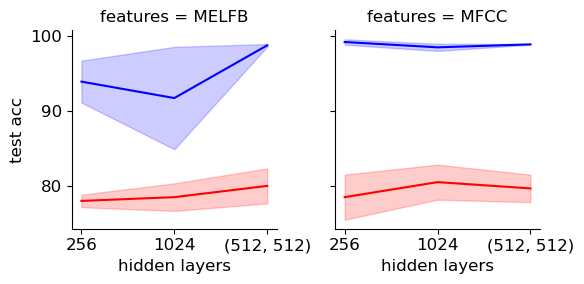

In [98]:
g=sns.FacetGrid(df_nn,col="features") 
g.map(sns.lineplot,"hidden layers","train acc",color='b')
g.map(sns.lineplot,"hidden layers","test acc",color='r')